# Evolution of commitment and level of participation in public goods games

### Import of library needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
#from tqdm import tqdm
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.numerical import PairwiseComparisonNumerical
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

### Definition of the PGG class

In [2]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                  group_size: int,   # number of participants in the PGG
                  c: float,          # cost of cooperation
                  r: float,          # enhancing factor (multiplier)
                  eps: float,        # cost for propose a commitment
                  delta : float,     # cost to don't respect the commitment
                  ):
          
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4, 5, 6, 7, 8

        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[COMP1] + group_composition[COMP2] + group_composition[COMP3] + group_composition[COMP4] + group_composition[COMP5]  # number of commitment
        
        if(nb_commitment==0):  # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else: #If one propose, we have can have a FREE player
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]  # number of contributors
        
        nb_fake = group_composition[FAKER]  # number of fake
        nb_accept = group_composition[FAKER] + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)

        # Find F
        F = int(0)
        comp = int(0)
        for i in group_composition[:5]:
          comp+=1
          if(i>0):
            F=comp

        if F <= nb_accept or nb_commitment==0: #le nombre de gens qui acceptent le contrat doit être plus grand que F
        #ou le nombre de COMP est égal à 0 et on joue juste un PGG classique
          for index, strategy_count in enumerate(group_composition):
              if strategy_count > 0:  # (else: it's not in the group, its payoff is 0)
                game_payoffs[index] += individual_reward
                if "COMP" in self.strategies[index]:
                  game_payoffs[index] -=  (self.c + (self.eps/nb_commitment)- ((nb_fake*self.delta)/nb_commitment))
                elif self.strategies[index] == "C":
                  game_payoffs[index] -=  self.c
                if(nb_commitment > 0):
                  if self.strategies[index] == "FAKE":
                    game_payoffs[index] -= self.delta
                  elif self.strategies[index] == "FREE":
                      game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


## 4.1 Constraints on the evolutionary viability of COMPF

In [3]:
# Parameters of the game:
strategy_labels = ["F=1","F=2","F=3","F=4","F=5" ,"C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 0.65
beta = 0.25
r = 4.
eps = 0.25
delta = 2.


In [5]:
game = PGGWithCommitment(group_size, c, r, eps, delta)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

### Figure 3.a

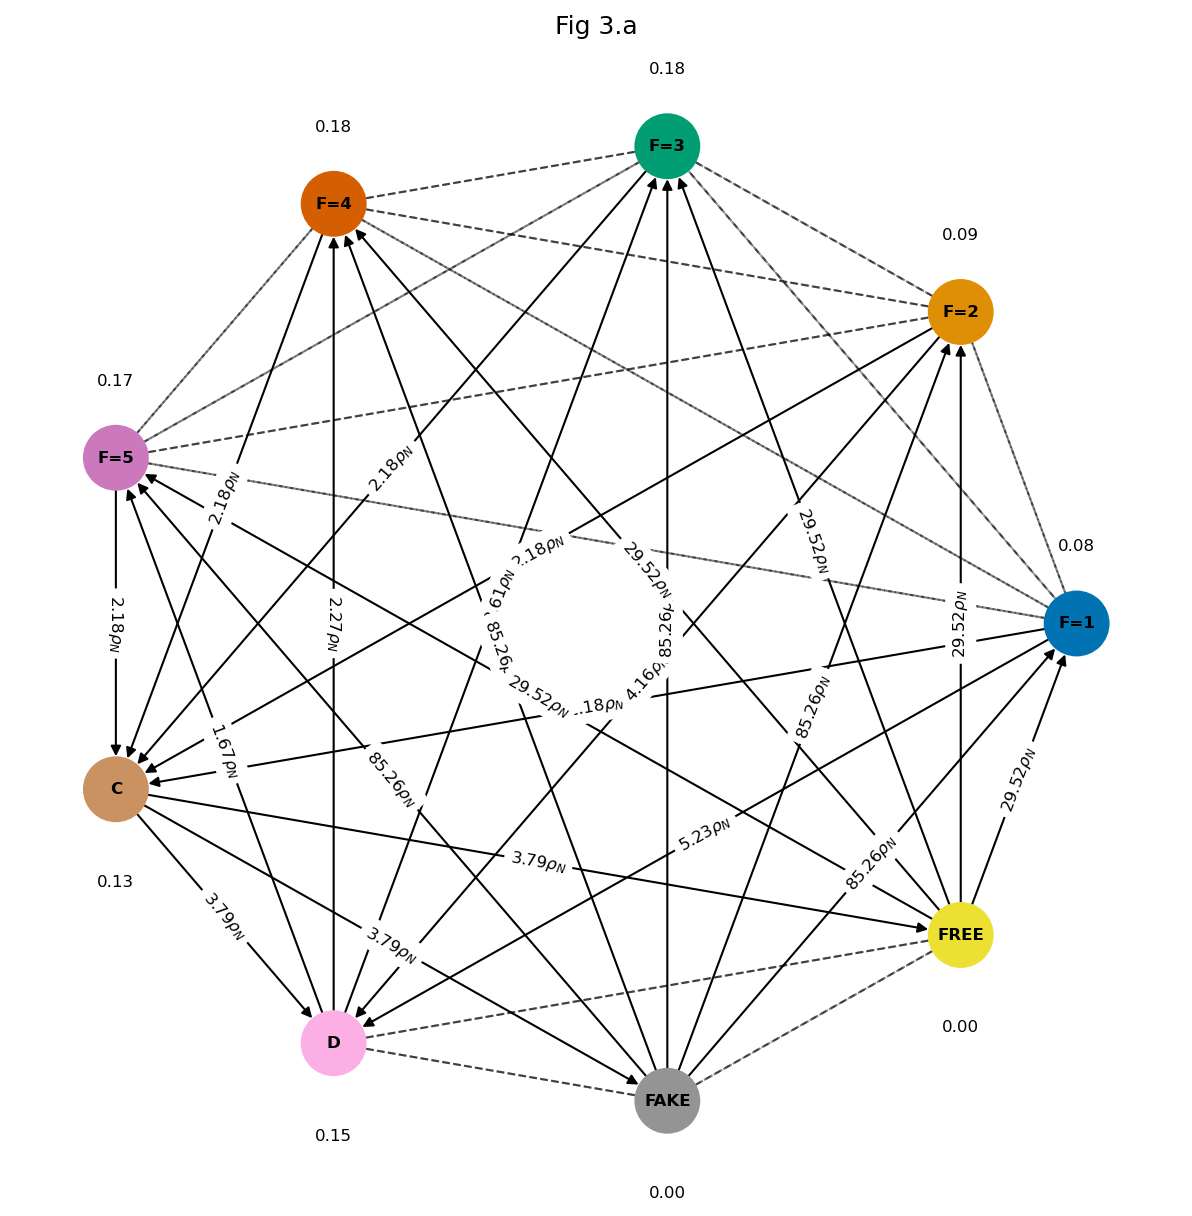

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.title("Fig 3.a")
plt.show() # display

### Figure 3.b and 3.c

In [14]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

avoid_frequency_b = np.zeros((nb_points, nb_points), dtype = float)
avoid_frequency_c = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        avoid_frequency_b[i,j] = sum(stationary_distribution[0:6])
        avoid_frequency_c[i,j] = sum(stationary_distribution[0:5])

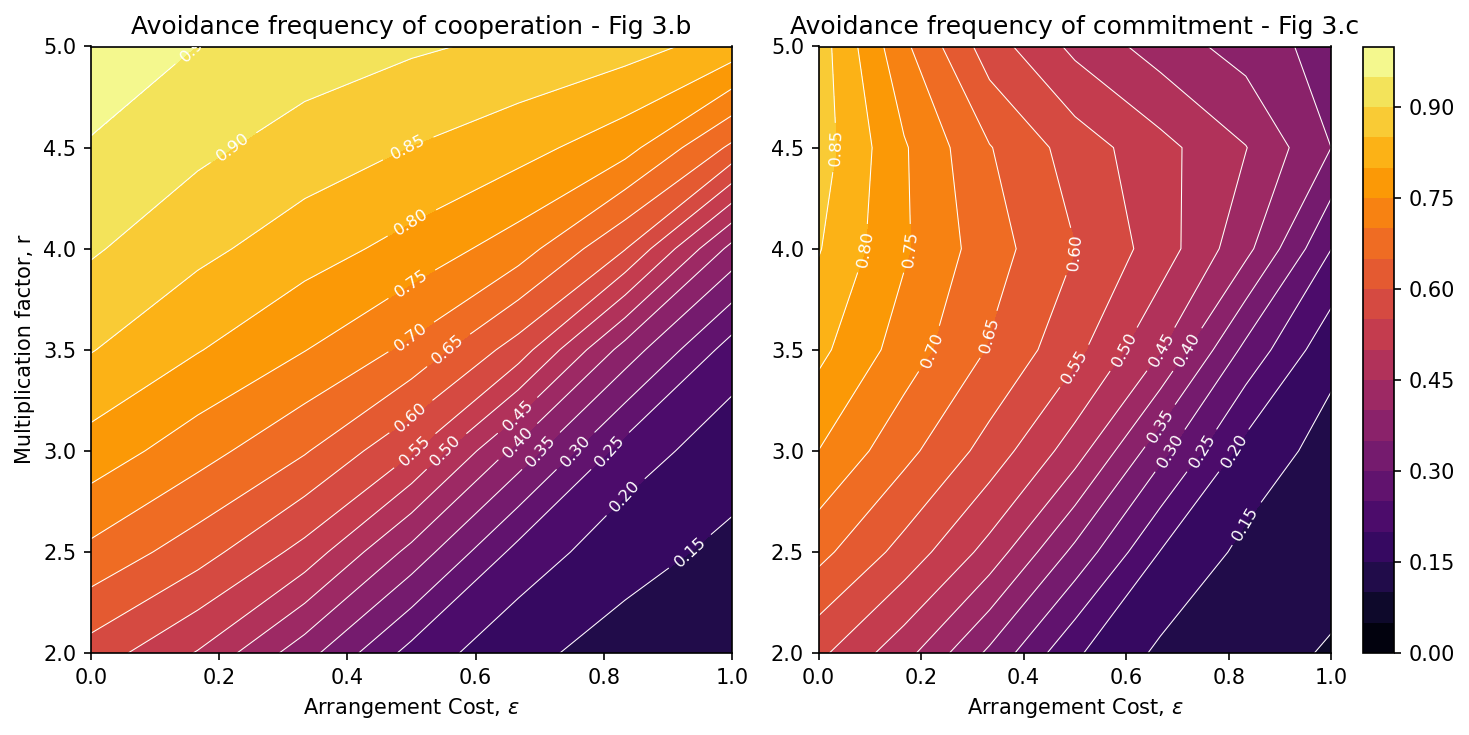

In [15]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(eps_values, r_values, avoid_frequency_b.T, levels=levels, cmap='inferno', vmin=0., vmax=1.)
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_b.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'Arrangement Cost, $\epsilon$')
plt.ylabel("Multiplication factor, r")
plt.title("Avoidance frequency of cooperation - Fig 3.b")

# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(eps_values, r_values, avoid_frequency_c.T, levels=levels, cmap='inferno', vmin=0., vmax=1.)
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_c.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, fontsize=8, fmt="%.2f") 
plt.xlabel(r'Arrangement Cost, $\epsilon$')
#plt.ylabel("Multiplication factor, r")
plt.title("Avoidance frequency of commitment - Fig 3.c")


plt.tight_layout()
plt.show()


## 4.2 Emergence of cooperation and sufficient participation levels

In [6]:
class PGGwithNormal(AbstractNPlayerGame):
    def __init__(self,
                 group_size: int,  # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                ):
        AbstractNPlayerGame.__init__(self, 2, group_size)
        self.nb_strategies_ = 2
        self.group_size_ = group_size

        self.strategies = ["C", "D"]  # Cooperate, Defect, Non-participate, Punish
        self.c = c
        self.r = r

        self.nb_group_configurations_ = self.nb_group_configurations()

        # payoffs in different group configurations
        self.calculate_payoffs()


    def play(self,
             group_composition: Union[List[int], np.ndarray],
             game_payoffs: np.ndarray
            ) -> None:
        game_payoffs[:] = 0.
        nb_contributors = group_composition[0]

        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)
        for index, strategy_count in enumerate(group_composition):
            game_payoffs[index] += individual_reward
            if self.strategies[index] == "C":
              game_payoffs[index] -=  self.c

    def calculate_payoffs(self) -> np.ndarray:
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        for i in range(self.nb_group_configurations_):
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            self.play(group_composition, payoffs_container)

            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)


            payoffs_container[:] = 0

        return self.payoffs()


### Plot Fig 4.a

In [34]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)
avoid_frequency_average = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(0.25)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        payoff_comp = (r*1.0) - 1.0 -(eps/5)
        payoff_C = r*1.0 - 1.0
        k = 0
        while k <= 4:
            avoid_frequency_average[i,j] += stationary_distribution[k] * payoff_comp
            k+=1
        
        avoid_frequency_average[i,j] += stationary_distribution[k] * payoff_C
        print("avoid freq")
        print(avoid_frequency_average)

avoid freq
[[0.54929635 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
avoid freq
[[0.54929635 0.99003699 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.

In [28]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)
epsilon_values =[0.,1.,3.,10.,100.,1000.]

avoid_frequency_average = np.zeros((nb_points, nb_points), dtype = float)

for k in range(0,len(epsilon_values)):
  epsilon = epsilon_values[k]
  for j in range(0,len(r_values)):
    i = 0
    r = r_values[j]
    payoff_comp = (r*1.0) - 1.0 -(epsilon/5)
    payoff_C = r*1.0 - 1.0
    print(payoff_C)
    epsilon = epsilon_values[k]
    game = PGGWithCommitment(group_size, c, r, epsilon, delta)

    evolver = PairwiseComparison(Z, game)

    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.25)

    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
    while i <= 4:
      avoid_frequency_average[k,j] += stationary_distribution[i] * payoff_comp
      i+=1
    avoid_frequency_average[k,j] += stationary_distribution[i] * payoff_C
    print("avoid freq")
    print(avoid_frequency_average)



1.0
avoid freq
[[0.54929635 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
1.5
avoid freq
[[0.54929635 0.99003699 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.   

In [37]:
r_values = np.linspace(2.0, 5.0, 7)
print(r_values)
for i in r_values:
    print(i)

[2.  2.5 3.  3.5 4.  4.5 5. ]
2.0
2.5
3.0
3.5
4.0
4.5
5.0


[[0.54929635 0.99003699 1.51870767 2.11139323 2.69517768 3.32056184
  3.90898611]
 [0.47741916 0.90417287 1.39618009 1.99010358 2.55895259 3.18402641
  3.81049525]
 [0.3932379  0.81701518 1.28285927 1.87029091 2.44142486 3.05017425
  3.72386447]
 [0.27910134 0.71128276 1.17606131 1.75150726 2.34086387 2.93557648
  3.64394168]
 [0.16646477 0.54826886 1.05304427 1.62842198 2.24777732 2.84369911
  3.5653472 ]
 [0.11336392 0.33098356 0.86463512 1.48344505 2.15083172 2.76879667
  3.4955844 ]
 [0.09174869 0.20788041 0.55382122 1.26755504 2.02699779 2.70069502
  3.44106748]]


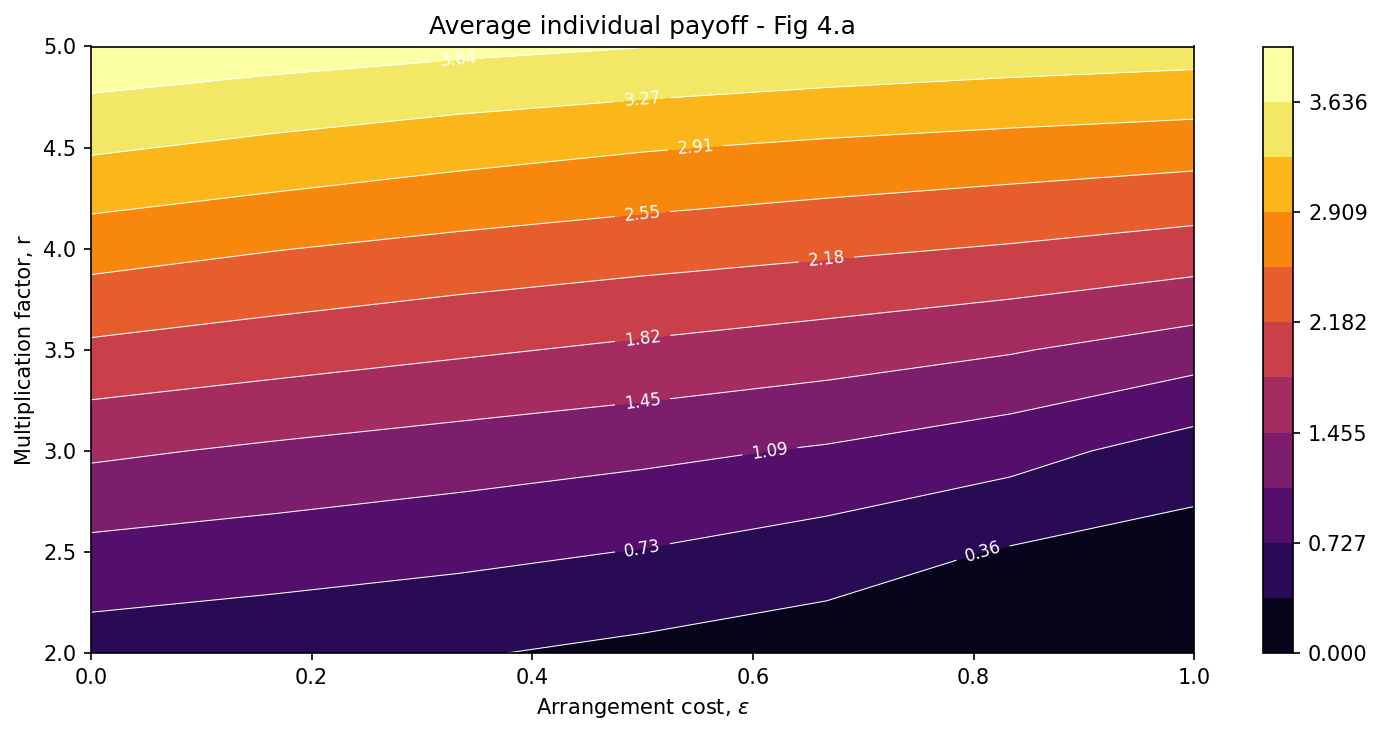

In [39]:
print(avoid_frequency_average)
levels = np.linspace(0., 4., 12)

plt.figure(figsize=(10, 5), dpi=150)
contour = plt.contourf(eps_values, r_values, avoid_frequency_average.T, levels=levels, cmap='inferno', vmin = 0., vmax = 3.7)
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_average.T, levels=levels , colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel("Multiplication factor, r")
plt.title("Average individual payoff - Fig 4.a")

plt.tight_layout()
plt.show()

### Plot Fig 4.b

In [7]:
epsilon_values =[0.,1.,3.,10.,100.,1000.]
r_values = np.arange(2, 5.25, 0.25)
payoffs_r = np.zeros(shape=(len(epsilon_values),len(r_values)), dtype=np.float64)
for k in range(0,len(epsilon_values)):
  epsilon = epsilon_values[k]
  for j in range(0,len(r_values)):
    i = 0
    r = r_values[j]
    payoff_comp = (r*1.0) - 1.0 -(epsilon/5)
    payoff_C = r*1.0 - 1.0
    epsilon = epsilon_values[k]
    if(epsilon==1000.):
      game = PGGwithNormal(group_size,c,r)
    else: 
      game = PGGWithCommitment(group_size, c, r, epsilon, delta)

    evolver = PairwiseComparison(Z, game)

    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.25)

    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
    if(epsilon<1000.):
      while i <= 4:
        payoffs_r[k][j] += stationary_distribution[i] * payoff_comp
        i+=1
    payoffs_r[k][j] += stationary_distribution[i] * payoff_C


c:\Users\theod\anaconda3\Lib\site-packages\egttools\utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


[0.26894142 0.73105858]


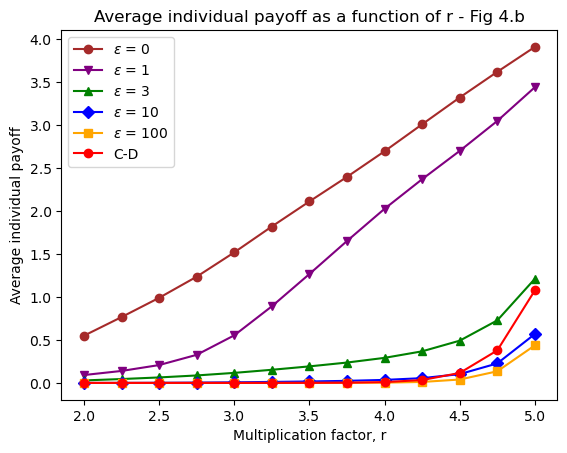

In [8]:
print(stationary_distribution)
a = [point for point in payoffs_r[0]]
b = [point for point in payoffs_r[1]]
g = [point for point in payoffs_r[2]]
d = [point for point in payoffs_r[3]]
e = [point for point in payoffs_r[4]]
f = [point for point in payoffs_r[5]]
plt.plot(r_values, a, color='brown',marker = 'o' ,label=r'$\epsilon$ = 0')
plt.plot(r_values, b, color='purple', marker = 'v' ,label=r'$\epsilon$ = 1')
plt.plot(r_values, g, color='green', marker = '^' ,label=r'$\epsilon$ = 3')
plt.plot(r_values, d, color='blue', marker = 'D' ,label=r'$\epsilon$ = 10')
plt.plot(r_values, e, color='orange',marker = 's' , label=r'$\epsilon$ = 100')
plt.plot(r_values, f, color='red',marker = 'o' , label='C-D')
plt.xlabel('Multiplication factor, r')
plt.ylabel('Average individual payoff')
plt.title('Average individual payoff as a function of r - Fig 4.b')
plt.legend()
plt.show()

## 4.3 Lenience in long-term commitments

### Plot Fig 5.a

In [4]:
# Parameters of the game:
strategy_labels = ["F=1","F=2","F=3","F=4","F=5" ,"C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 0.65
beta = 0.25
delta = 6.

In [14]:
nb_points = 5
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

average_F = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        average_F[i, j] = sum(stationary_distribution[0:5] * np.arange(1, 6)) / sum(stationary_distribution[0:5])

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(average_F)
print("Min : ", np.min(average_F))
print("Max : ", np.max(average_F))

Matrice des moyennes F :
[[3.7906016  3.6271594  3.42048757 3.22835294 3.08789808]
 [3.76259582 3.65800342 3.49713773 3.33246118 3.17063471]
 [3.78356    3.64349961 3.52101505 3.39990197 3.26167507]
 [3.82556757 3.70431768 3.52883728 3.40666051 3.32574879]
 [3.83071038 3.76209005 3.63087491 3.42707567 3.32456088]]
Min :  3.087898084001717
Max :  3.830710384494713


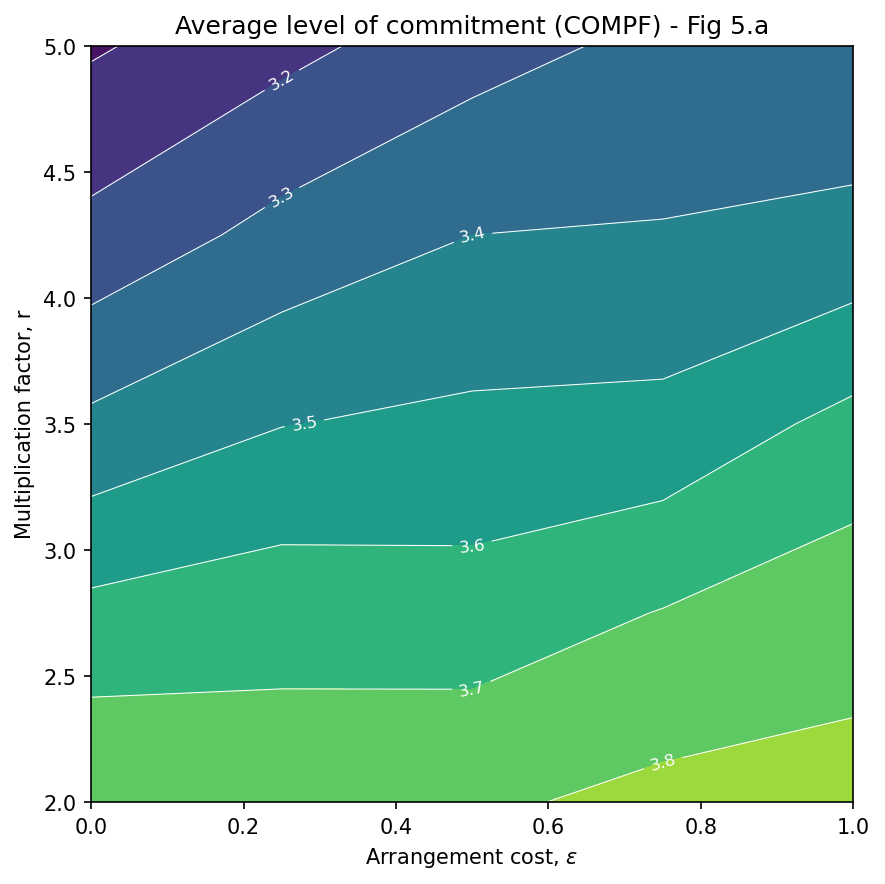

In [15]:
# Plot the average level of commitment
plt.figure(figsize=(6, 6), dpi=150)

levels = np.linspace(3.0, 4.0, 11)
contour = plt.contourf(eps_values, r_values, average_F.T, levels=levels, cmap='viridis')
contour_lines = plt.contour(eps_values, r_values, average_F.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f")
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel('Multiplication factor, r')
plt.title('Average level of commitment (COMPF) - Fig 5.a')
#plt.colorbar(contour)

plt.tight_layout()
plt.show()

### Plot Fig 5.b

In [5]:
nb_points = 10
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

optimal_F = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F)
print("Min : ", np.min(optimal_F))
print("Max : ", np.max(optimal_F))

Matrice des moyennes F :
[[5. 5. 4. 4. 4. 4. 3. 3. 3. 3.]
 [5. 5. 4. 4. 4. 4. 3. 3. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 3. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 3. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 3. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 4. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 4. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 4. 3. 3.]
 [5. 5. 5. 4. 4. 4. 4. 4. 4. 3.]
 [5. 5. 5. 5. 4. 4. 4. 4. 4. 3.]]
Min :  3.0
Max :  5.0


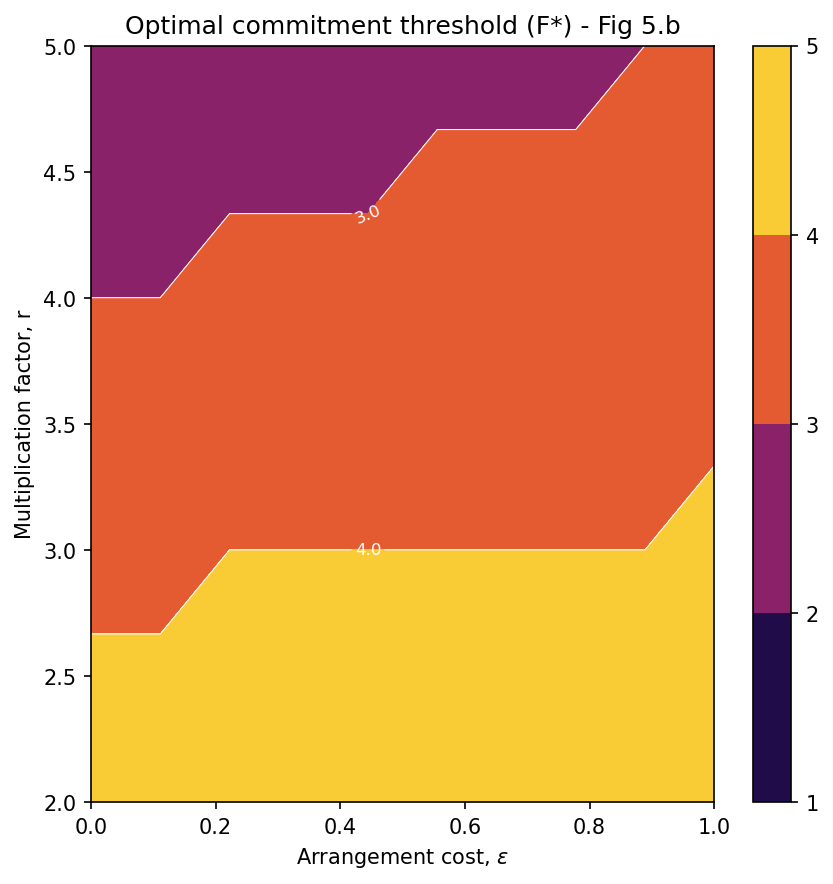

In [7]:
# Tracer la figure
plt.figure(figsize=(6, 6), dpi=150)

levels = np.linspace(1.0, 5.0, 5)
contour = plt.contourf(eps_values, r_values, optimal_F.T, levels=levels, cmap='inferno')
contour_lines = plt.contour(eps_values, r_values, optimal_F.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f")
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel('Multiplication factor, r')
plt.title('Optimal commitment threshold (F*) - Fig 5.b')
plt.colorbar(contour)
plt.tight_layout()
plt.show()

### Plot Fig 5.c and Fig 5.d

In [24]:
c = 0.65
r_c = 2.5
nb_points = 6
eps_values = np.linspace(0., 2., nb_points)
delta_values = np.linspace(0., 6., nb_points)

optimal_F_r25 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        game = PGGWithCommitment(group_size, c, r_c, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F_r25[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F_r25)
print("Min : ", np.min(optimal_F_r25))
print("Max : ", np.max(optimal_F_r25))

Matrice des moyennes F :
[[4. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]]
Min :  4.0
Max :  5.0


In [25]:
r_d = 4.0
nb_points = 6
eps_values = np.linspace(0., 2., nb_points)
delta_values = np.linspace(0., 6., nb_points)

optimal_F_r40 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        game = PGGWithCommitment(group_size, c, r_d, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F_r40[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F_r40)
print("Min : ", np.min(optimal_F_r40))
print("Max : ", np.max(optimal_F_r40))

Matrice des moyennes F :
[[3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]]
Min :  3.0
Max :  4.0


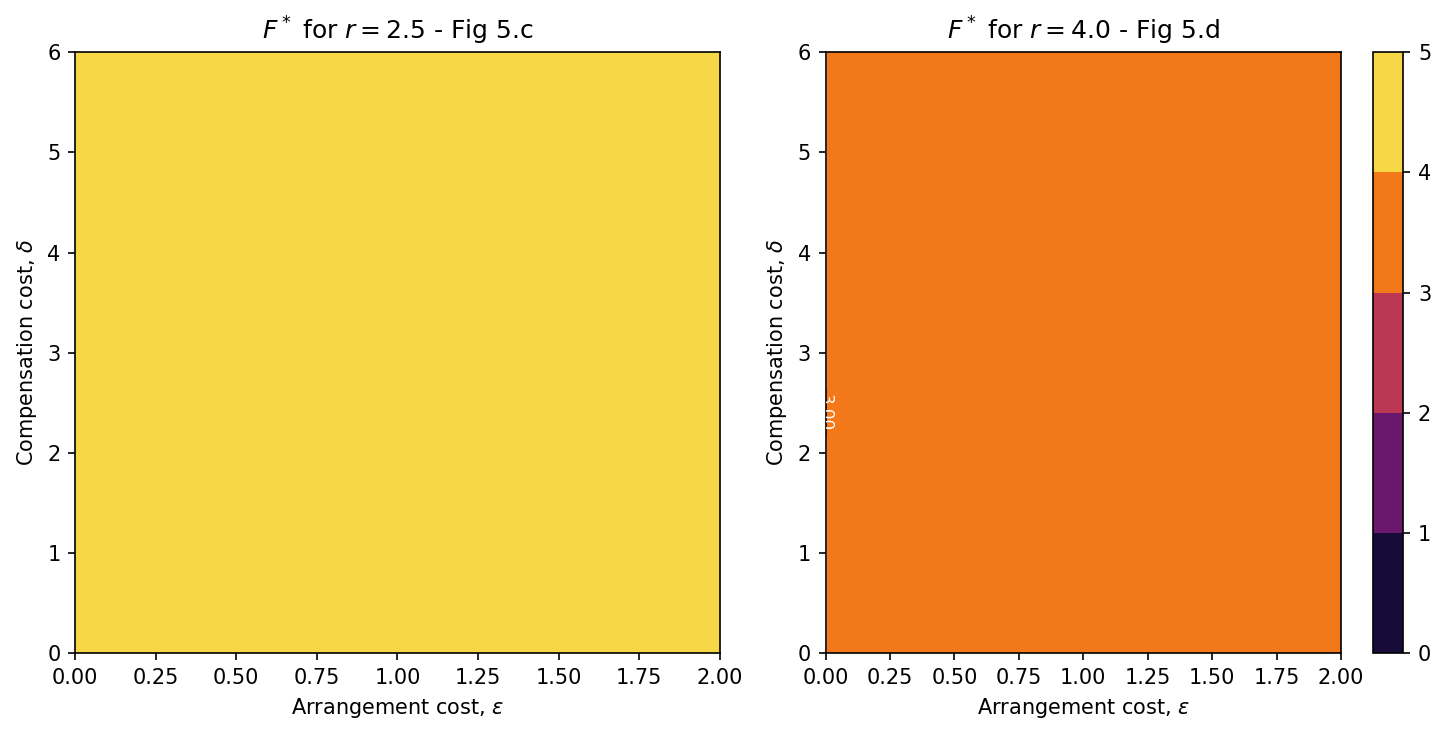

In [23]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 5., 6)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(eps_values, delta_values, optimal_F_r25.T, levels=levels, cmap='inferno')
contour_lines = plt.contour(eps_values, delta_values, optimal_F_r25.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel(r'Compensation cost, $\delta$')
plt.title(r'$F^*$ for $r = 2.5$ - Fig 5.c')

# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(eps_values, delta_values, optimal_F_r40.T, levels=levels, cmap='inferno')
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, delta_values, optimal_F_r40.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, fontsize=8, fmt="%.2f") 
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel(r'Compensation cost, $\delta$')
plt.title(r'$F^*$ for $r = 4.0$ - Fig 5.d')


plt.tight_layout()
plt.show()

# Plot figure 6.a and 6.b with 29 strats

Les gains entre deux types différents de stratégies COMP_F,F′ sont les mêmes que les gains entre deux types différents de stratégies COMP_F dans le jeu en une seule manche (i.e. 
𝑟
𝑐
−
𝑐
−
𝑁
rc−c−N), car ils s'engagent tous et coopèrent à toutes les manches.

### THEO run here

PGG class defintion 

In [3]:
class PGGWithLongCommitment29(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 R: int             # Number of rounds
                 ):
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 29, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 29
        self.group_size_ = group_size
        self.strategies = [
            "COMP1_1", "COMP1_2", "COMP1_3", "COMP1_4", "COMP1_5",
            "COMP1_2", "COMP2_2", "COMP3_2", "COMP4_2", "COMP5_2",
            "COMP1_3", "COMP2_3", "COMP3_3", "COMP4_3", "COMP5_3",
            "COMP1_4", "COMP2_4", "COMP3_4", "COMP4_4", "COMP5_4",
            "COMP1_5", "COMP2_5", "COMP3_5", "COMP4_5", "COMP5_5",
            "C", "D", "FAKE", "FREE"
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.R = R  # Number of rounds
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1_1, COMP1_2, COMP1_3, COMP1_4, COMP1_5 = 0, 1, 2, 3, 4
        COMP1_2, COMP2_2, COMP3_2, COMP4_2, COMP5_2 = 5, 6, 7, 8, 9
        COMP1_3, COMP2_3, COMP3_3, COMP4_3, COMP5_3 = 10, 11, 12, 13, 14
        COMP1_4, COMP2_4, COMP3_4, COMP4_4, COMP5_4 = 15, 16, 17, 18, 19
        COMP1_5, COMP2_5, COMP3_5, COMP4_5, COMP5_5 = 20, 21, 22, 23, 24
        COOPERATOR, DEFECTOR, FAKER, FREE = 25, 26, 27, 28
        # Calculate the number of each type of player in the group
        nb_commitment = sum(group_composition[:25])  # Number of commitment strategies

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]

        nb_fake = group_composition[FAKER]  # Number of fake players
        nb_accept = nb_fake + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        # Determine F (minimum commitment threshold) and F_prime
        F = next((i + 1 for i, count in enumerate(group_composition[:25]) if count > 0), 0)
        F_prime = next((int(self.strategies[i].split('_')[-1]) for i in range(25) if group_composition[i] > 0 and '_' in self.strategies[i]), 0)
    
        for period in range(self.R):
            if (nb_commitment >= 1):
                if(F <= nb_accept) : 
                    for index, strategy_count in enumerate(group_composition):
                        if strategy_count > 0:  # Players in the group
                            game_payoffs[index] += individual_reward

                            if index == COOPERATOR:
                                game_payoffs[index] -= self.c
                            if index == FREE:
                                game_payoffs[index] -= self.c
                            if index == FAKER:
                                    game_payoffs[index] -= self.delta
                            if index < 25:  # COMP strategies
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))

                else:
                    for index, strategy_count in enumerate(group_composition):
                        if strategy_count > 0:  # Players in the group
                            game_payoffs[index] += individual_reward

                            if index == COOPERATOR:
                                game_payoffs[index] -= self.c
                            if index == FREE:
                                game_payoffs[index] -= self.c
                            if index == FAKER:
                                if nb_contributors >= F_prime:
                                    pass
                                else:
                                    game_payoffs[index] -= self.delta

                            if index < 25:  # COMP strategies
                                if nb_contributors >= F_prime:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment))
                                else:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))
                            if nb_contributors < F_prime:
                                game_payoffs[index] = (1/self.R) * game_payoffs[index]


            elif(nb_commitment == 0): # Classical PGG
                for index, strategy_count in enumerate(group_composition):
                    if strategy_count > 0:
                        game_payoffs[index] += individual_reward
                        if index == COOPERATOR:
                            game_payoffs[index] -= self.c
                        else :
                            pass # No cost for other strategies

            else: # Game not played
                return  

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in tqdm(range(self.nb_group_configurations_)):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0
        return self.payoffs()


Test on game PGG

In [ ]:
# Paramètres
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 100  # Taille de la population
beta = 0.25  # Intensité de la sélection
mu = 0.01  # Probabilité de mutation
R_values = np.array([2, 5, 10, 50, 100])  # Nombre de rounds
r_values = np.linspace(2.0, 5.0, 5)  # Facteur multiplicatif

# Stockage des résultats
average_F_prime = np.zeros((len(r_values), len(R_values)))
optimal_F_prime = np.zeros((len(r_values), len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        # Initialisation du jeu
        game = PGGWithLongCommitment29(group_size, c, r, eps, delta, R)
        print("game created")   
        # Initialisation de la dynamique évolutive
        evolver = PairwiseComparisonNumerical(Z, game,cache_size=2500)
        print("Calcul de la matrice de transition")
        # Estimation de la distribution stationnaire
        stationary_distribution = evolver.estimate_stationary_distribution_sparse(
            nb_runs=10,             # Nombre de simulations indépendantes
            nb_generations=1000,    # Nombre total de générations
            transitory=100,         # Période transitoire exclue
            beta=beta,               # Intensité de sélection
            mu=mu                    # Probabilité de mutation
        )
        print("Estimation de la distribution stationnaire")

        # Extraction des fréquences des stratégies COMP
        comp_frequencies = stationary_distribution[:5]  # COMP1 à COMP5
        F_prime_levels = np.arange(1, 6)  # Correspondance des niveaux F' (1, 2, ..., 5)

        # Calcul de F' moyen
        if np.sum(comp_frequencies) > 0:
            average_F_prime[j, i] = np.dot(F_prime_levels, comp_frequencies) / np.sum(comp_frequencies)
        else:
            average_F_prime[j, i] = 0  # Défaut si aucune stratégie COMP n'est présente

        # Calcul de F' optimal (basé sur la fréquence maximale)
        optimal_F_prime[j, i] = F_prime_levels[np.argmax(comp_frequencies)]


### Run this one (sml)

In [5]:
# Parameters
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 20  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2, 5, 10, 50, 100])
r_values = np.linspace(2.0, 5.0, 5)  # Example range for r

# Storage for results
average_F_prime = np.zeros((len(r_values), len(R_values)))
optimal_F_prime = np.zeros((len(r_values), len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        # Initialize the game
        game = PGGWithLongCommitment29(group_size, c, r, eps, delta,R)
        print("game initialized")
        # Calculate the stationary distribution
        evolver = PairwiseComparison(Z, game)
        print("evolver initialized")
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        print("transition matrix calculated")
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        print(i,"/5", "/n")
        # Extract COMP strategy frequencies (indices 0 to 4 in stationary_distribution)
        comp_frequencies = stationary_distribution[:5]  # COMP1 to COMP5
        F_prime_levels = np.arange(1, 6)  # Corresponding F' levels (1, 2, ..., 5)

        # Calculate average F'
        if np.sum(comp_frequencies) > 0:
            #average_F_prime[i, j] = sum(freq_COMPF * F_values) / freq_sum
            average_F_prime[j, i] = np.dot(F_prime_levels, comp_frequencies) / np.sum(comp_frequencies)
        else:
            average_F_prime[j,i] = 0  # Default if no COMP strategies are present

        # Calculate optimal F' (based on max frequency)
        optimal_F_prime[j, i] = F_prime_levels[np.argmax(comp_frequencies)]

100%|██████████| 237336/237336 [00:10<00:00, 23198.37it/s]

# Figure 6 by fixing F

### Definition of the PGG

In [6]:
class PGGWithLongCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 R: int,            # Number of rounds
                 F_prime: int       # Secondary threshold F'
                 ):
    
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = [
            "COMP1", "COMP2", "COMP3", "COMP4", "COMP5",
            "C", "D", "FAKE", "FREE"
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.F_prime = F_prime
        self.R = R  # Number of rounds
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5 = 0, 1, 2, 3, 4
        COOPERATOR, DEFECTOR, FAKER, FREE = 5, 6, 7, 8
        # Calculate the number of each type of player in the group
        nb_commitment = sum(group_composition[:5])  # Number of commitment strategies

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]

        nb_fake = group_composition[FAKER]  # Number of fake players
        nb_accept = nb_fake + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        # Determine F (minimum commitment threshold) and F_prime
        F = next((i + 1 for i, count in enumerate(group_composition[:5]) if count > 0), 0)

        for period in range(self.R):
            if (nb_commitment >= 1):
                if(F <= nb_accept) : 
                    for index, strategy_count in enumerate(group_composition):
                        if strategy_count > 0:  # Players in the group
                            game_payoffs[index] += individual_reward

                            if index == COOPERATOR:
                                game_payoffs[index] -= self.c
                            if index == FREE:
                                game_payoffs[index] -= self.c
                            if index == FAKER:
                                game_payoffs[index] -= self.delta

                            if index < 5:  # COMP strategies
                                if nb_contributors >= self.F_prime:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))
                                else:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / (nb_commitment)))
                                    break

                else: # Game not played
                    return 

            elif(nb_commitment == 0): # Classical PGG
                for index, strategy_count in enumerate(group_composition):
                    if strategy_count > 0:
                        game_payoffs[index] += individual_reward
                        if index == COOPERATOR:
                            game_payoffs[index] -= self.c
                        else :
                            pass # No cost for other strategies

            else: # Game not played
                return  

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0
        return self.payoffs()


In [2]:
class PGGWithLongCommitmentInverse(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 R: int,            # Number of rounds
                 F_prime: int       # Secondary threshold F'
                 ):
    
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = [
            "COMP1", "COMP2", "COMP3", "COMP4", "COMP5",
            "C", "D", "FAKE", "FREE"
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.F_prime = F_prime
        self.R = R  # Number of rounds
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5 = 0, 1, 2, 3, 4
        COOPERATOR, DEFECTOR, FAKER, FREE = 5, 6, 7, 8
        # Calculate the number of each type of player in the group
        nb_commitment = sum(group_composition[:5])  # Number of commitment strategies

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]

        nb_fake = group_composition[FAKER]  # Number of fake players
        nb_accept = nb_fake + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        # Determine F (minimum commitment threshold) and F_prime
        F = next((i + 1 for i, count in enumerate(group_composition[:5]) if count > 0), 0)

        for period in range(self.R):
            if (nb_commitment >= 1):

                if(self.F_prime <= nb_accept) : 
                    for index, strategy_count in enumerate(group_composition):
                        if strategy_count > 0:  # Players in the group
                            game_payoffs[index] += individual_reward

                            if index == COOPERATOR:
                                game_payoffs[index] -= self.c
                            if index == FREE:
                                game_payoffs[index] -= self.c
                            if index == FAKER:
                                    game_payoffs[index] -= self.delta
                            if index < 5:  # COMP strategies
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))

                else:
                    for index, strategy_count in enumerate(group_composition):
                        if strategy_count > 0:  # Players in the group
                            game_payoffs[index] += individual_reward

                            if index == COOPERATOR:
                                game_payoffs[index] -= self.c
                            if index == FREE:
                                game_payoffs[index] -= self.c
                            if index == FAKER:
                                if nb_contributors >= F:
                                    pass
                                else:
                                    game_payoffs[index] -= self.delta

                            if index < 5:  # COMP strategies
                                if nb_contributors >= F:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment))
                                else:
                                    game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))
                            if nb_contributors < F :
                                game_payoffs[index] = (1/self.R) * game_payoffs[index]


            elif(nb_commitment == 0): # Classical PGG
                for index, strategy_count in enumerate(group_composition):
                    if strategy_count > 0:
                        game_payoffs[index] += individual_reward
                        if index == COOPERATOR:
                            game_payoffs[index] -= self.c
                        else :
                            pass # No cost for other strategies

            else: # Game not played
                return  

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition

            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0
        return self.payoffs()


### Computing loop of average and optimality

In [13]:
# Parameters
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2, 5, 10, 50, 100])
r_values = np.linspace(2.0, 5.0, 5)  # Example range for r

# Storage for results
average_F_prime = np.zeros((len(r_values), len(R_values)))
optimal_F_prime = np.zeros((len(r_values), len(R_values)))


for i, R in tqdm(enumerate(R_values)):
    for j, r in enumerate(r_values):
        for idF in range(1, 6): 
            # Initialize the game
            game = PGGWithLongCommitmentInverse(group_size, c, r, eps, delta,R, idF)
            # Calculate the stationary distribution
            evolver = PairwiseComparison(Z, game)
            transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
            stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

            # Extract COMP strategy frequencies (indices 0 to 4 in stationary_distribution)
            comp_frequencies = stationary_distribution[:5]  # COMP1 to COMP5
            F_prime_levels = np.arange(1, 6)  # Corresponding F' levels (1, 2, ..., 5)

            # Calculate average F'
            if np.sum(comp_frequencies) > 0:
                #average_F_prime[i, j] = sum(freq_COMPF * F_values) / freq_sum
                average_F_prime[j, i] = np.dot(F_prime_levels, comp_frequencies) / np.sum(comp_frequencies)
            else:
                average_F_prime[j,i] = 0  # Default if no COMP strategies are present

            # Calculate optimal F' (based on max frequency)
            optimal_F_prime[j, i] = F_prime_levels[np.argmax(comp_frequencies)]




0it [00:00, ?it/s]

0it [00:43, ?it/s]


KeyboardInterrupt: 

In [3]:
# Parameters
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2, 5, 10, 50, 100])
r_values = np.linspace(2.0, 5.0, 5)  # Example range for r

# Storage for results
average_F_prime = np.zeros((len(r_values), len(R_values)))
optimal_F_prime = np.zeros((len(r_values), len(R_values)))


for i, R in tqdm(enumerate(R_values)):
    for j, r in enumerate(r_values):
        comp_tot = np.zeros(5)
        for idF in range(1, 6): 
            # Initialize the game
            game = PGGWithLongCommitmentInverse(group_size, c, r, eps, delta,R, idF)
            # Calculate the stationary distribution
            evolver = PairwiseComparison(Z, game)
            transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
            stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

            # Extract COMP strategy frequencies (indices 0 to 4 in stationary_distribution)
            comp_frequencies = stationary_distribution[:5]  # COMP1 to COMP5
            comp_tot = [c_F + new_F for c_F, new_F in zip(comp_tot, comp_frequencies)]

        optimal_F_prime[j, i] = np.argmax(comp_tot) + 1

5it [12:08, 145.64s/it]


average_F_prime [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


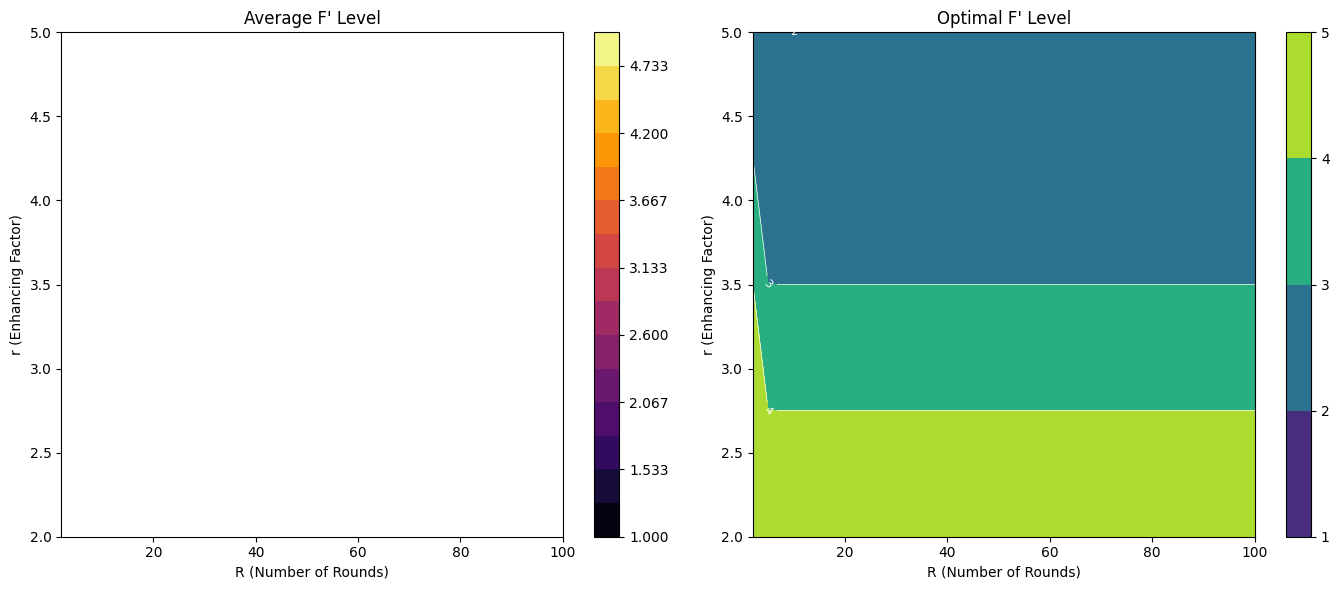

In [16]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
print("average_F_prime", average_F_prime)
# Average F' contour plot
ax = axs[0]
levels = np.linspace(1., 5., 16)
contour = ax.contourf(R_values, r_values, average_F_prime, levels=levels, cmap='inferno')
contour_lines = ax.contour(R_values, r_values, average_F_prime, levels=levels, colors='white', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")
ax.set_title("Average F' Level")

ax.set_xlabel("R (Number of Rounds)")
ax.set_ylabel("r (Enhancing Factor)")
fig.colorbar(contour, ax=ax)

# Optimal F' contour plot
ax = axs[1]
levels = np.linspace(1., 5., 5)
contour = ax.contourf(R_values, r_values, optimal_F_prime, levels=levels, cmap='viridis')
contour_lines = ax.contour(R_values, r_values, optimal_F_prime, levels=levels, colors='white', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%d")
ax.set_title("Optimal F' Level")
ax.set_xlabel("R (Number of Rounds)")
ax.set_ylabel("r (Enhancing Factor)")
fig.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()